In [1]:
import nflgame
import matplotlib.pyplot as plt

# returns the field position as the number of yards away from the opposing team's end zone
def field_pos_to_number(pos):
    pos = pos.split(" ")
    if pos[0] == "MIDFIELD":
        return 50
    elif pos[0] == "OWN":
        return 100-int(pos[1])
    elif pos[0] == "OPP":
        return int(pos[1])
    
# returns the current game clock as a quarter, clock tuple
def clock_to_nums(clock):
    clock = clock.split(" ")
    clock[0] = min(int(clock[0][1:]), 5)
    return clock[0], clock[1]

# returns the current play in a different format
def convert_play(p):
    quarter, time = clock_to_nums(p[2])
    return [quarter, time, p[3], p[4], field_pos_to_number(p[5]), p[-5], p[-4], p[-3], p[-2], p[-1]]
    
# get number of points scored on the conversion attempt after a touchdown
def get_conversion(plays, scores, i):
    # use list of scoring plays to figure out conversions
    if i < len(scores):
        #print(scores[i])
        if " TD " in scores[i]:
            if "failed" in scores[i]:
                return 0, i+1
            if "kick is good" in scores[i]:
                return 1, i+1
            if "run)" in scores[i] or "pass)" in scores[i]:
                return 2, i+1
            if i < len(scores)-1 and "defensive two point conversion" in scores[i+1]:
                return -1, i+2
    return 0, i+1

# get all plays for a given game in the proper format
def get_all_plays2(game, spread):   
    plays = nflgame.combine_plays([game])
    scores = game.scores
    score_index = 0
    home = 0
    away = 0
    win = (game.score_home >= game.score_away)
    plays2 = []
    for p in plays:
        plays2.append(p)

    all_plays = []
    for i in range(len(plays2)):
        p = plays2[i]
        if (p.down > 0 and str(p.time) != "None" and str(p.yardline) != "None"): # or p.note == "KICKOFF":
            # add play to all plays
            temp_play = [game.home, game.away, str(p.time), p.down, p.yards_togo, 
                         str(p.yardline), p.home, home, away, spread, win]
            all_plays.append(convert_play(temp_play))
#         if (not p.note == None) and len(p.note) >= 2 and (p.note[:2] == "2P" or p.note[:2] == "XP"):
#             print(p.note)
        # do scoring stuff
        if p.note == "TD":
            pts = 6
            is_home = p.home
            if p.punting_tot == 1:
                is_home = (not is_home)
            if p.defense_tds == 1:
                is_home = (not is_home)
#             is_home = True
#             if (not p.home and p.defense_tds != 1) or (p.home and p.defense_tds == 1):
#                 is_home = False
            conv, score_index = get_conversion(plays2, scores, score_index)
            # add conversion points if it wasn't a defensive 2 point conversion
            if conv != -1:
                pts += conv
            if is_home:
                home += pts
            else:
                away += pts
            # handle defensive 2 point conversion 
            if conv == -1:
                if is_home:
                    away += 2
                else:
                    home += 2
            #print(str(home) + "-" + str(away))

        elif p.note == "FG":
            if p.home:
                home += 3
            else:
                away += 3
            score_index += 1
                
        elif p.note == "SAF":
            if scores[score_index].split("-")[0][:-1] == str(game.home):
                home += 2
            else:
                away += 2
            score_index += 1

    return home, away, all_plays

def fix_name(t):
    if t == "SD":
        t = "LAC"
    if t == "LA" or t == "STL":
        t = "LAR"
    if t == "JAC":
        t = "JAX"
    return t

# get all plays from all weeks in weeks and all seasons in years. calls get_all_plays2
def get_plays(years, weeks, indexes=-1):
    all_plays = []
    for y in years:
        print(y)
        for w in weeks:
            #print(w)
            try:
                games = nflgame.games(y, week=w, kind='REG')
            except:
                continue
            current = data[(data["schedule_season"] == y) & (data["schedule_week"] == str(w))]
            if not indexes == -1:
                games = [games[i] for i in indexes]
            for g in games:
                t1 = g.home
                t2 = g.away
                t1 = fix_name(t1)
                t2 = fix_name(t2)
                #print(t2)
                spread = list(current.loc[(current["team1"] == t1) & (current["team2"] == t2)]["vegas_spread"])
                if len(spread) > 0:
                    h, a, cur_plays = get_all_plays2(g, spread[0])
                    if h != g.score_home or a != g.score_away:
                        #print("Actual: " + str(g.score_home) + "-" + str(g.score_away) + ", Mine: " + str(h) + "-" + 
                          #    str(a) + " " + str(g.home) + " " +str(g.away))
                        continue
                    all_plays += cur_plays
    return all_plays

# final model?
def collect_plays(all_plays):
    # collect plays and add interaction terms
    x_data = []
    y_data = []
    for p in all_plays:
        qtr = p[0]
        time = p[1].split(":")
        if len(time[0]) == 0:
            continue
        mins_left = 15*(4-min(qtr,4))+int(time[0])
        secs_left = int(time[1])
        time_left = round(mins_left + secs_left/60.,2)

        x_data.append([time_left]+p[2:-1])
        y_data.append(1 if p[-1] else 0)

    df = pd.DataFrame(x_data, columns=["time", "down", "distance", "fieldpos", "homeposs", "score_home", 
                                      "score_away", "spread"])

    # basic terms
    df["scorediff"] = df["score_home"] - df["score_away"]
    df["down1"] = df["down"].apply(lambda x : 1 if x == 1 else 0)
    df["down2"] = df["down"].apply(lambda x : 1 if x == 2 else 0)
    df["down3"] = df["down"].apply(lambda x : 1 if x == 3 else 0)
    df["down4"] = df["down"].apply(lambda x : 1 if x == 4 else 0)
    df["homeposs"] = df["homeposs"].apply(lambda x : 1 if x else 0)
    
    # interaction terms
    df["down1*poss"] = df["down1"] * df["homeposs"]
    df["down2*poss"] = df["down2"] * df["homeposs"]
    df["down3*poss"] = df["down3"] * df["homeposs"]
    df["down4*poss"] = df["down4"] * df["homeposs"]
    df["distance*poss"] = df["distance"] * df["homeposs"]
    df["fieldpos*poss"] = df["fieldpos"] * df["homeposs"]
    
    # more interaction terms
    df["time*poss"] = (60-df["time"]) * df["homeposs"]
    df["time*spread"] = df["time"] * df["spread"]
    df["time*scorediff"] = (60-df["time"]) * df["scorediff"]
    df["fgrange"] = df["fieldpos"].apply(lambda x : 1 if x <= 35 else 0)
    df["fgrange*poss"] = df["fgrange"] * df["homeposs"]

    # additional terms
    df["last5"] = df["time"].apply(lambda x : 1 if x <= 5 else 0)
    df["close"] = df["scorediff"].apply(lambda x : 1 if abs(x) <= 8 else 0)
    df["last5min_close"] = df["last5"] * df["close"]
    df["last5min_close_poss"] = df["last5min_close"] * df["homeposs"]
    
    # score correction
    df["sqrt_time"] = df["time"].apply(lambda x : 1 + np.sqrt(x))
    df["score_correction"] = df["scorediff"] / df["sqrt_time"]
    
    df.drop(["score_correction", "homeposs", "down", "score_home", "score_away", "last5", 
             "close", "sqrt_time"], axis=1, inplace=True)
    
    return df, y_data

def remove_features(df):
    df.drop(["time*poss", "time*spread", "time*scorediff", "fgrange", "fgrange*poss", 
             "last5min_close", "last5min_close_poss"], axis=1, inplace=True)
    return df

def check_wp(x, y, model, threshold):
    y_pred = model.predict(x)
    
    results = []
    for i in range(len(y_pred)):
        if abs(y_pred[i]-threshold) <= 0.01:
            if y[i] == 1:
                results.append(1)
            else:
                results.append(0)
    #print(count)
    m = np.mean(results)
    return m, np.sqrt(m*(1-m)/len(results))

def check_wp2(x, y, model, threshold):
    y_pred = model.predict(x)
    time_left = list(x["time"])
    
    results = []
    for i in range(len(y_pred)):
        if time_left[i] > 5:
            continue
        if abs(y_pred[i]-threshold) <= 0.01:
            if y[i] == 1:
                results.append(1)
            else:
                results.append(0)
    #print(count)
    m = np.mean(results)
    return m, np.sqrt(m*(1-m)/len(results))

# check accuracy using original mse thing
def check_model_accuracy(test_x, test_y, model, last5):
    x = np.arange(0,1.01,0.05)
    y = []
    ses = []
    se = 0
    for i in x:
        if not last5:
            cur_mean, cur_se = check_wp(test_x, test_y, model, i)
        else:
            cur_mean, cur_se = check_wp2(test_x, test_y, model, i)
        y.append(cur_mean)
        ses.append(cur_se)
        print(str(round(i,2)) + ": " + str(round(cur_mean,3)) + ", SE = " + str(round(cur_se, 3)))
        se += (cur_mean-i)**2

    print("")
    print("mse: " + str(se/len(x)))

    plt.close()
    plt.plot(x,x) # for reference
    plt.plot(x,y)
    plt.xlabel("k")
    plt.ylabel("Winning probability")
    #plt.savefig("/Users/Bill/Documents/Fall 2019/THesis/interimreport/plot1.png")
    plt.show()
    
# check accuracy using the brier score
def check_model_accuracy2(test_x, test_y, model):
    x = np.arange(0,1.01,0.05)
    y = []
    se = 0
    count = 0
    for i in x:
        cur_mean, cur_se, cur_num = get_brier(test_x, test_y, model, i)
        y.append(cur_mean)
        print(str(round(i,2)) + ": " + str(round(cur_mean,3)))
        se += cur_se
        count += cur_num

    print("")
    print("brier score: " + str(se/count))

    plt.close()
    plt.plot(x,x) # for reference
    plt.plot(x,y)
    plt.xlabel("k")
    plt.ylabel("Winning probability")
    #plt.savefig("/Users/Bill/Documents/Fall 2019/THesis/interimreport/plot1.png")
    plt.show()
    
def get_brier(x, y, model, threshold):
    y_pred = model.predict(x)
    
    results = []
    errors = []
    
    y_pred = list(y_pred)
    for i in range(len(y_pred)):
        if abs(y_pred[i]-threshold) <= 0.01:
            if y[i] == 1:
                results.append(1)
            else:
                results.append(0)
            errors.append((y[i]-y_pred[i])**2)
    #print(count)
    return np.mean(results), sum(errors), len(errors)

# check accuracy using the brier score
def check_model_accuracy_all(test_x, test_y, model):
    x = np.arange(0,1.01,0.05)
    y = []
    brier = 0
    se = 0
    count = 0
    for i in x:
        cur_mean, cur_brier, cur_num = get_brier(test_x, test_y, model, i)
        y.append(cur_mean)
        print(str(round(i,2)) + ": " + str(round(cur_mean,3)))
        brier += cur_brier
        se += (cur_mean-i)**2
        count += cur_num

    print("")
    print("mse: " + str(se/len(x)))
    print("brier score: " + str(brier/count))

    plt.close()
    plt.plot(x,x) # for reference
    plt.plot(x,y)
    plt.xlabel("k")
    plt.ylabel("Winning probability")
    #plt.savefig("/Users/Bill/Documents/Fall 2019/THesis/interimreport/plot1.png")
    plt.show()
    
# check accuracy using the brier score
def check_model_accuracy_times(old_test_x, old_test_y, model, start_time, end_time):
    indices = old_test_x.index[(old_test_x["time"] <= start_time) & (old_test_x["time"] >= end_time)].tolist()
    test_x = old_test_x.loc[indices, :]
    test_y = [old_test_y[i] for i in indices]
    
    #print(test_x.head())
    
    x = np.arange(0,1.01,0.05)
    y = []
    brier = 0
    se = 0
    count = 0
    for i in x:
        cur_mean, cur_brier, cur_num = get_brier(test_x, test_y, model, i)
        y.append(cur_mean)
        print(str(round(i,2)) + ": " + str(round(cur_mean,3)))# + ", brier: " + str(round(cur_brier/cur_num, 3)))
        brier += cur_brier
        se += (cur_mean-i)**2
        count += cur_num

    print("")
    print("mse: " + str(se/len(x)))
    print("brier score: " + str(brier/count))

    plt.close()
    plt.plot(x,x) # for reference
    plt.plot(x,y)
    plt.xlabel("k")
    plt.ylabel("Winning probability")
    #plt.savefig("/Users/Bill/Documents/Fall 2019/THesis/interimreport/plot1.png")
    plt.show()
    
# check accuracy using the brier score
def check_model_accuracy_times_pca(old_old_test_x, old_test_x, old_test_y, model, start_time, end_time):
    indices = old_test_x.index[(old_old_test_x["time"] <= start_time) & 
                               (old_old_test_x["time"] >= end_time)].tolist()
    test_x = old_test_x.loc[indices, :]
    test_y = [old_test_y[i] for i in indices]
    
    #print(test_x.head())
    
    x = np.arange(0,1.01,0.05)
    y = []
    brier = 0
    se = 0
    count = 0
    for i in x:
        cur_mean, cur_brier, cur_num = get_brier(test_x, test_y, model, i)
        y.append(cur_mean)
        print(str(round(i,2)) + ": " + str(round(cur_mean,3)))# + ", brier: " + str(round(cur_brier/cur_num, 3)))
        brier += cur_brier
        se += (cur_mean-i)**2
        count += cur_num

    print("")
    print("mse: " + str(se/len(x)))
    print("brier score: " + str(brier/count))

    plt.close()
    plt.plot(x,x) # for reference
    plt.plot(x,y)
    plt.xlabel("k")
    plt.ylabel("Winning probability")
    #plt.savefig("/Users/Bill/Documents/Fall 2019/THesis/interimreport/plot1.png")
    plt.show()

In [2]:
import pandas as pd
import random
import numpy as np
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

# get spread data
data = pd.read_csv("elo_and_vegas_spreads2.csv")

data = data.drop(data.columns[0], axis=1)
data = data[data["schedule_season"] >= 2009]
data = data[data["schedule_playoff"] == False]
data.drop(["schedule_playoff"],axis=1,inplace=True)

# get training and testing data
train_fraction = 0.7

years = [i for i in range(2009,2019)]
weeks = [i for i in range(1,18)]
plays = get_plays(years,weeks)

x_data, y_data = collect_plays(plays)

# convert to lists, randomize
cols = list(x_data)
x_data = x_data.values.tolist()
alldata = list(zip(x_data, y_data))
random.shuffle(alldata)
x_data, y_data = zip(*alldata)
x_data = list(x_data)
y_data = list(y_data)

# simpler model
x_data2 = pd.DataFrame(data=np.array(x_data), columns=cols)
x_data2 = remove_features(x_data2)
cols2 = list(x_data2)
x_data2 = x_data2.values.tolist()

# take the appropriate training and testing sets
num_points = int(train_fraction*len(x_data))
train_x = pd.DataFrame(x_data[:num_points], columns=cols)
train_y = y_data[:num_points]
test_x = pd.DataFrame(x_data[num_points:], columns=cols)
test_y = y_data[num_points:]

# training and testing for simpler model
train_x2 = pd.DataFrame(x_data2[:num_points], columns=cols2)
test_x2 = pd.DataFrame(x_data2[num_points:], columns=cols2)

/Users/Bill/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


2009
2010
2011
2012
2013
2014
2015
2016
2017
2018


In [22]:
from sklearn.svm import LinearSVR
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

cols = list(train_x)
train_x_values = StandardScaler().fit_transform(train_x.values)
new_train_x = pd.DataFrame(data=train_x_values, columns=cols)

svr_model = LinearSVR()
svr_model.fit(new_train_x, train_y)

cols = list(train_x2)
train_x_values = StandardScaler().fit_transform(train_x2.values)
new_train_x2 = pd.DataFrame(data=train_x_values, columns=cols)

svr_model2 = LinearSVR()
svr_model2.fit(new_train_x2, train_y)

LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=0.0001, verbose=0)

full svm full game
0.0: 0.026
0.05: 0.058
0.1: 0.072
0.15: 0.097
0.2: 0.136
0.25: 0.194
0.3: 0.244
0.35: 0.318
0.4: 0.356
0.45: 0.385
0.5: 0.457
0.55: 0.522
0.6: 0.581
0.65: 0.631
0.7: 0.686
0.75: 0.75
0.8: 0.814
0.85: 0.827
0.9: 0.876
0.95: 0.897
1.0: 0.931

mse: 0.0016340546751368664
brier score: 0.17970390858860155


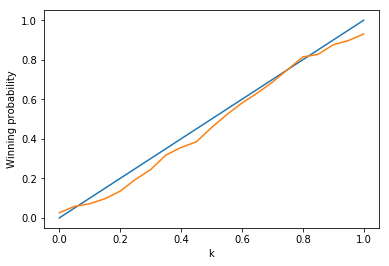

full svm last 5
0.0: 0.0
0.05: 0.0
0.1: 0.0
0.15: 0.0
0.2: 0.019
0.25: 0.016
0.3: 0.0
0.35: 0.227
0.4: 0.0
0.45: 0.0
0.5: 0.062
0.55: 0.105
0.6: 0.217
0.65: 0.305
0.7: 0.513
0.75: 0.718
0.8: 0.86
0.85: 0.85
0.9: 0.953
0.95: 0.96
1.0: 0.979

mse: 0.06138267690809705
brier score: 0.153996691853119


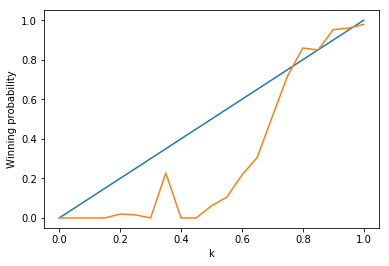

simplified svm full game
0.0: 0.02
0.05: 0.021
0.1: 0.042
0.15: 0.085
0.2: 0.112
0.25: 0.157
0.3: 0.199
0.35: 0.243
0.4: 0.333
0.45: 0.376
0.5: 0.432
0.55: 0.495
0.6: 0.57
0.65: 0.62
0.7: 0.685
0.75: 0.736
0.8: 0.797
0.85: 0.831
0.9: 0.875
0.95: 0.9
1.0: 0.941

mse: 0.0035010636059663526
brier score: 0.18238981629918016


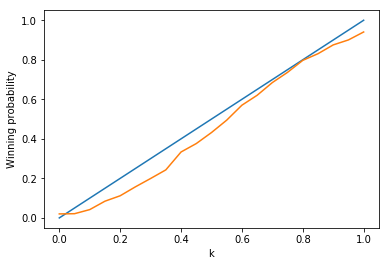

simplified svm last 5
0.0: 0.0
0.05: 0.0
0.1: 0.008
0.15: 0.058
0.2: 0.096
0.25: 0.111
0.3: 0.204
0.35: 0.279
0.4: 0.402
0.45: 0.449
0.5: 0.596
0.55: 0.614
0.6: 0.713
0.65: 0.76
0.7: 0.837
0.75: 0.917
0.8: 0.961
0.85: 0.966
0.9: 0.987
0.95: 0.973
1.0: 1.0

mse: 0.009338613659886247
brier score: 0.14657962454249768


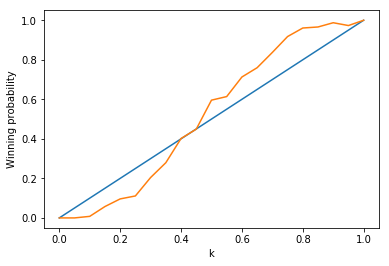

In [23]:
cols = list(test_x)
new_test_x = StandardScaler().fit_transform(test_x.values)
new_test_x = pd.DataFrame(data=new_test_x, columns=cols)

print("full svm full game")
check_model_accuracy_times(new_test_x, test_y, svr_model, 10, -10)

print("full svm last 5")
check_model_accuracy_times(new_test_x, test_y, svr_model, -1.368, -10)

cols = list(test_x2)
new_test_x2 = StandardScaler().fit_transform(test_x2.values)
new_test_x2 = pd.DataFrame(data=new_test_x2, columns=cols)

print("simplified svm full game")
check_model_accuracy_times(new_test_x2, test_y, svr_model2, 10, -10)

print("simplified svm last 5")
check_model_accuracy_times(new_test_x2, test_y, svr_model2, -1.368, -10)